In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

In [2]:
petrodf = yf.download("ITUB3.SA", start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df = pd.DataFrame()
df['adj_close'] = petrodf['Adj Close']
df['Time'] = np.arange(len(petrodf.index))
df['Lag_1'] = df['adj_close'].shift(1)

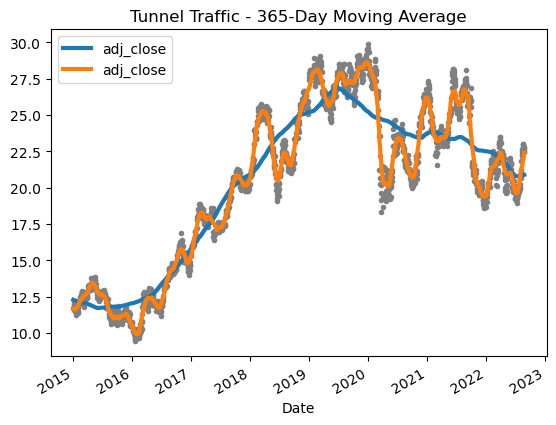

In [4]:
moving_average_365 = df['adj_close'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

moving_average_30 = df['adj_close'].rolling(
    window=30,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=15,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df['adj_close'].plot(style=".", color="0.5")
moving_average_365.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=True,
);
moving_average_30.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=True,
);
pyplot.show();

In [5]:
df['MA365'] = moving_average_365
df['MA30'] = moving_average_30

In [20]:
df

,adj_close,Time,Lag_1,MA365,MA30
Date,,,,,
2015-01-02,11.719545,0,NaN,12.295077,11.667619
2015-01-05,11.587220,1,11.719545,12.285489,11.667556
2015-01-06,11.700636,2,11.587220,12.276357,11.667278
2015-01-07,11.965271,3,11.700636,12.267650,11.666401
2015-01-08,12.135386,4,11.965271,12.259676,11.660244
...,...,...,...,...,...
2022-08-22,22.450001,1898,22.700001,20.863257,21.969444
2022-08-23,22.450001,1899,22.450001,20.869742,22.078647
2022-08-24,22.600000,1900,22.450001,20.876680,22.187923


# Seasonality

## Fourier features

In [18]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    period=7,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

F = dp.in_sample()  # create features for dates in tunnel.index

In [19]:
F

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2015-01-05,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
2015-01-06,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.085965,0.996298,...,0.493776,0.869589,0.566702,0.823923,0.635432,0.772157,0.699458,0.714673,0.758306,0.651899
2015-01-07,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.103102,0.994671,...,0.580800,0.814046,0.661635,0.749826,0.735417,0.677615,0.801361,0.598181,0.858764,0.512371
2015-01-08,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.120208,0.992749,...,0.661635,0.749826,0.746972,0.664855,0.821477,0.570242,0.884068,0.467359,0.933837,0.357698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22,1.0,1899.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.763889,-0.645348,...,-0.875892,0.482508,0.196673,-0.980469,0.622047,0.782980,-0.999546,-0.030120,0.668064,-0.744104
2022-08-23,1.0,1900.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.774884,-0.632103,...,-0.821477,0.570242,0.077386,-0.997001,0.723644,0.690173,-0.992222,0.124479,0.530730,-0.847541
2022-08-24,1.0,1901.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.785650,-0.618671,...,-0.758306,0.651899,-0.043022,-0.999074,0.811539,0.584298,-0.961130,0.276097,0.377708,-0.925925


# Lags

In [7]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.adj_close, lags=4)
X = X.fillna(0.0)

In [8]:
X

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Date,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000
2015-01-05,11.719545,0.000000,0.000000,0.000000
2015-01-06,11.587220,11.719545,0.000000,0.000000
2015-01-07,11.700636,11.587220,11.719545,0.000000
2015-01-08,11.965271,11.700636,11.587220,11.719545
...,...,...,...,...
2022-08-22,22.700001,22.973499,23.022840,22.953762
2022-08-23,22.450001,22.700001,22.973499,23.022840
2022-08-24,22.450001,22.450001,22.700001,22.973499


In [9]:
y = df['adj_close']

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

In [10]:
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Date,,,,,,,,
2015-01-02,11.719545,11.587220,11.700636,11.965271,12.135386,11.987947,11.594784,11.488933
2015-01-05,11.587220,11.700636,11.965271,12.135386,11.987947,11.594784,11.488933,11.519174
2015-01-06,11.700636,11.965271,12.135386,11.987947,11.594784,11.488933,11.519174,11.583439
2015-01-07,11.965271,12.135386,11.987947,11.594784,11.488933,11.519174,11.583439,11.757339
2015-01-08,12.135386,11.987947,11.594784,11.488933,11.519174,11.583439,11.757339,11.417103
...,...,...,...,...,...,...,...,...
2022-08-11,22.302452,22.499819,22.697186,22.953762,23.022840,22.973499,22.700001,22.450001
2022-08-12,22.499819,22.697186,22.953762,23.022840,22.973499,22.700001,22.450001,22.450001
2022-08-15,22.697186,22.953762,23.022840,22.973499,22.700001,22.450001,22.450001,22.600000


In [11]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [12]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [14]:
# !pip install xgboost

In [15]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [16]:
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Date,,,,,,,,
2020-09-18,21.015169,20.804163,20.924648,20.947710,21.093822,21.352369,21.099997,21.029099
2020-09-21,20.592863,20.611404,20.036390,20.037184,19.968962,20.531021,20.483671,20.240910
2020-09-22,20.402637,20.367245,20.169041,19.751823,20.109701,20.588509,20.483665,19.989685
2020-09-23,20.260674,20.252615,19.980097,20.043280,20.507074,20.760256,20.534498,20.169765
2020-09-24,20.233345,20.016922,19.788691,20.317793,20.494221,20.324942,20.181221,19.992975
...,...,...,...,...,...,...,...,...
2022-08-11,22.348534,22.057152,21.889496,22.064255,20.206093,22.604053,21.882389,22.528049
2022-08-12,22.507406,22.479565,22.954821,22.164995,22.466545,22.587252,22.584867,21.662291
2022-08-15,22.266600,22.530176,22.508608,22.699631,22.253593,22.293081,22.321104,22.518618


In [ ]:
ax = df['adj_close'].plot(style=".", color="0.5")
moving_average_365.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=True,
);
moving_average_30.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=True,
);
pyplot.show();